<a href="https://colab.research.google.com/github/lmbd92/st1800-st1801-trabajo3-2261/blob/main/Trabajo3Lina_Jose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integrantes: Lina Beltrán (lbeltra1@eafit.edu.co), Jose Muñoz (jjmunozm@eafit.edu.co)

Materia: Alm. & Recu. de información.

Trabajo 3

Universidad EAFIT - Maestria ciencia en datos y analítica

Trabajo 2 Unidad 2 recuperación de texto

Data: https://github.com/lmbd92/st1800-st1801-trabajo3-2261/blob/main/Trabajo3/twitter.txt

# Abrir archivos desde GitHub

In [1]:
# OJO!!!! Ejecutar este bloque una sola vez (Por cada sesión iniciada)

!git clone -l -s https://github.com/lmbd92/st1800-st1801-trabajo3-2261.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 102 (delta 58), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (102/102), 30.63 MiB | 14.39 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/cloned-repo
LICENSE    Trabajo3		    twitterClimateData.csv.zip
README.md  Trabajo3Lina_Jose.ipynb


In [2]:
# Delete repo local colab (Usar solo en caso de requerir actualizar el repo desde Github Nuevamente)

#!rm -r /content/cloned-repo

**Nota:** Para guardar el notebook directamente en Github, dirigirse a File→Save a copy in GitHub

# Preparación de ambiente de trabajo (Dependencias/librerias)

In [3]:
# Transmisión eficiente de archivos muy grandes desde/hacia almacenamientos como S3, GCS, Azure Blob Storage, HDFS, WebHDFS
!pip install smart-open

# Modelado y procesamiento NLP
!pip install --upgrade gensim
!pip install nltk

# Interpretar el tema en un modelo de temas que se ha ajustado a un corpus
!pip install pyLDAvis

     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=d89cb1d9d3951532c61430f6c6e7933a0be414f3ab21d4bea669aa13809567f7
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [4]:
import pandas as pd
import numpy as np
import nltk
import matplotlib as plt
# Soporte para expresiones regulares (RE).
import re

In [5]:
# nltk: tokenizador y stopwords

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words_nltk = set(stopwords.words('english'))
print(len(stopwords.words('english')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
179


In [6]:
#Lematizar, Stem
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
#
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [7]:
#imprimir listas grandes
import pprint
from pprint import pprint

# Carga de Data Raw y EDA básico



In [8]:
# Carga de los datos

path_in = '/content/cloned-repo/Trabajo3/'
path_out = '/content/cloned-repo/Trabajo3/out/'
file_name = 'twitterClimateData.csv'

df = pd.read_csv(f'{path_in}{file_name}')
df.head()

,Unnamed: 0,id,author_id,text,retweets,permalink,date,formatted_date,favorites,mentions,...,location,text_clean,tb_sentiment_polarity,tb_sentiment_subjectivity,textBlob_sentiment,vader_compound,vader_pos,vader_neg,vader_neu,V_Sentiment
0,0,1.211810e+18,7.590000e+17,"2020 is the year we #votethemout, the year we ...",15,https://twitter.com/Sphiamia/status/1211807074...,2019-12-31 00:31:35+00:00,Tue Dec 31 00:31:35 +0000 2019,46,NaN,...,"California, USA",2020 is the year we votethemout the year we cl...,-0.100000,0.462500,negative,-0.5682,0.000,0.131,0.869,Negative
1,1,1.210670e+18,2.219547e+07,Winter has not stopped this group of dedicated...,9,https://twitter.com/StephDujarric/status/12106...,2019-12-27 20:56:21+00:00,Fri Dec 27 20:56:21 +0000 2019,35,NaN,...,"California, USA",Winter has not stopped this group of dedicated...,0.000000,0.000000,positive,0.5670,0.215,0.000,0.785,Positive
2,2,1.210590e+18,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,545,https://twitter.com/AlexandriaV2005/status/121...,2019-12-27 15:50:22+00:00,Fri Dec 27 15:50:22 +0000 2019,3283,@UN @Fridays4future,...,"California, USA",WEEK 55 of ClimateStrike at the UN Next week F...,0.166667,0.333333,positive,-0.8567,0.023,0.180,0.797,Negative
3,3,1.210260e+18,1.339821e+09,"A year of resistance, as youth protests shape...",1,https://twitter.com/EnergyHouseVA/status/12102...,2019-12-26 17:53:26+00:00,Thu Dec 26 17:53:26 +0000 2019,2,NaN,...,"California, USA",A year of resistance as youth protests shaped...,0.183333,0.600000,positive,0.7739,0.203,0.051,0.746,Positive
4,4,1.209640e+18,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,1,https://twitter.com/EnergyHouseVA/status/12096...,2019-12-25 00:56:37+00:00,Wed Dec 25 00:56:37 +0000 2019,4,NaN,...,"California, USA",HAPPY HOLIDAYS greta gretathunberg climatecha...,0.650000,0.800000,positive,0.9413,0.451,0.000,0.549,Positive


In [9]:
df.shape

(72405, 24)

In [10]:
df.count()

Unnamed: 0                   72405
id                           72405
author_id                    72405
text                         72405
retweets                     72405
permalink                    72405
date                         72405
formatted_date               72405
favorites                    72405
mentions                     27554
hashtags                     72402
geo                              0
urls                         33349
search_hashtags              72405
location                     72405
text_clean                   72405
tb_sentiment_polarity        72405
tb_sentiment_subjectivity    72405
textBlob_sentiment           72405
vader_compound               72405
vader_pos                    72405
vader_neg                    72405
vader_neu                    72405
V_Sentiment                  72405
dtype: int64

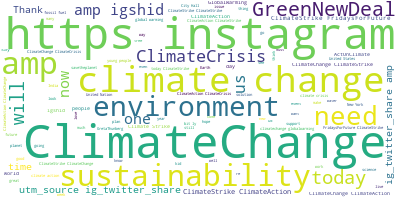

In [11]:
# Importar wordcloud Libreria
from wordcloud import WordCloud
# Unir palabras y caracteres Raw
long_string = ','.join(list(df['text'].values))
# Crear objeto de nube de palabras
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generar nube de palabras
wordcloud.generate(long_string)
# Visualización
wordcloud.to_image()

# Preparación de data, Nubes de tokens y Frecuencia

Definimos funcion para optimizar incluyendo stem y Lematización

In [12]:
def textprep(line):
    tokens = nltk.word_tokenize(str(line))
    tokens = [w.lower() for w in tokens if len(w)>1]
    tokens = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
    tokens = [w for w in tokens if w not in stop_words_nltk] 
    tokens= [wordnet_lemmatizer.lemmatize(w) for w in tokens]
    tokens= [lancaster.stem(w) for w in tokens]
    return tokens

In [13]:
#Filtramos solo la columna de interés
text_df = df[['text']]
text_df.head()

,text
0,"2020 is the year we #votethemout, the year we ..."
1,Winter has not stopped this group of dedicated...
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...
3,"A year of resistance, as youth protests shape..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...


In [14]:
# creación de columna con tokenización de la columna de interés especifica
text_df['tokens_twitter'] = text_df.apply(lambda row: textprep(row['text']), axis=1)
text_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,tokens_twitter
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ..."
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo..."
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida..."
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec..."


Representación Frecuencia Visual del BoW optimizado

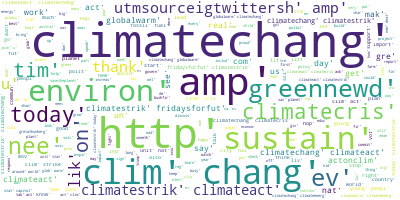

In [15]:
#Convertir Tokens en Lista y Str
tokens_twitter_list=text_df['tokens_twitter'].to_list()
tokens_twitter_str=" ".join([str(item) for item in tokens_twitter_list])
# Crear nube de palabras
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generar nube de palabras
wordcloud.generate(tokens_twitter_str)
# Visualización
wordcloud.to_image()

# Características y representación

Construir el BoW (diccionario) de términos

In [16]:
# Creación del BoW - en gensim es Dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary(text_df.tokens_twitter)
print(dictionary)

Dictionary(77295 unique tokens: ['2020', '33', 'climatestrik', 'don', 'els']...)


In [17]:
# Bag-of-words representacion de documentos.
corpus = [dictionary.doc2bow(line) for line in text_df.tokens_twitter]

In [18]:
for i in corpus[:10]:
    print(i)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4)]
[(2, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]
[(0, 1), (2, 1), (6, 1), (15, 1), (16, 1), (17, 1), (24, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2)]
[(0, 1), (2, 1), (15, 1), (16, 1), (17, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2)]
[(2, 1), (17, 1), (49, 1), (51, 1), (52, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (63, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)]
[(2, 1), (17, 2), (36, 1), (50, 1), (52, 1), (54, 1), (56, 1), (57, 1), (78, 1), (79,

Construir matriz de documentos vs términos

In [19]:
# libreria para paralelizar
import multiprocessing as mp
import time

pool = mp.Pool(mp.cpu_count())
doc_term_matrix = pool.map(dictionary.doc2bow, [sentence for sentence in text_df.tokens_twitter])
pool.close()

In [20]:
for i in doc_term_matrix[:10]:
    print(i)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4)]
[(2, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]
[(0, 1), (2, 1), (6, 1), (15, 1), (16, 1), (17, 1), (24, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2)]
[(0, 1), (2, 1), (15, 1), (16, 1), (17, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2)]
[(2, 1), (17, 1), (49, 1), (51, 1), (52, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (63, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)]
[(2, 1), (17, 2), (36, 1), (50, 1), (52, 1), (54, 1), (56, 1), (57, 1), (78, 1), (79,

# Modelo no supervisado LDA

Modelo LDA

In [21]:
#from gensim.models.ldamulticore import LdaMulticore

#t0 = time.time()
#lda_model = LdaMulticore(doc_term_matrix, num_topics=20, id2word = dictionary, passes=10, workers=10)
#print(time.time()-t0)

In [22]:
# Build LDA model Otro modelo lda, tiene otro nombr para no confundirse
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel


In [23]:
for i in range(15,20):
  lda_model2 = models.LdaModel(corpus=corpus,id2word=dictionary,num_topics=i, passes=5, alpha='auto')

  # Compute Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model2, texts=text_df['tokens_twitter'], dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('Coherence Score :', coherence_lda)


Coherence Score : 0.4377160621632605
Coherence Score : 0.3737651155249152
Coherence Score : 0.33673595067206596
Coherence Score : 0.3587837881465699
Coherence Score : 0.37000285707383584


In [26]:
lda_model2 = models.LdaModel(corpus=corpus,id2word=dictionary,num_topics=15, passes=5, alpha='auto')

In [27]:
coherence_model_lda = CoherenceModel(model=lda_model2, texts=text_df['tokens_twitter'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score :', coherence_lda)

Coherence Score : 0.38669430706347224


In [24]:
print(lda_model2)

LdaModel(num_terms=77295, num_topics=19, decay=0.5, chunksize=2000)


In [ ]:
def assigntopic(doc):
    vector = lda_model2[dictionary.doc2bow(doc)] 
    # opción 1: todos los tópicos ordenados de mayor a menor, podria ser topN tambien asi: return vector[:5] n=5
    #vector = sorted(vector, key=lambda item: -item[1])
    # opción 2: asignar el tópico mayor a cada documento
    vector = max(vector,key=lambda item: item[1])
    return vector

In [ ]:
text_df['topics'] = text_df.apply(lambda row: assigntopic(row['tokens_twitter']), axis=1)
text_df.head(10)

In [ ]:
topic_list = text_df['topics'].to_list()
print(topic_list)

In [ ]:
topic_id = [i[0] for i in topic_list]
print(topic_id)

In [ ]:
text_df['topic_id'] = topic_id
text_df.head(10)

In [ ]:
tokens_topics_df= text_df[['tokens_twitter','topic_id']]
tokens_topics_df.head(10)

In [ ]:
text_df.head(10)

In [ ]:
# Imprimir Keyword en los topics
pprint(lda_model2.print_topics())
doc_lda = lda_model2[corpus]


In [ ]:
len(doc_lda)
len(lda_model2.print_topics())

Analizando Resultados del LDA 

In [ ]:
#from pyLDAvis 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

#LDAvis_data_filepath = os.path.join(')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model2, corpus, dictionary)
    with open("/content/cloned-repo/Trabajo3/out", 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open("/content/cloned-repo/Trabajo3/out", 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/cloned-repo/Trabajo3/out.html')
LDAvis_prepared

Guardar Topics

In [ ]:
lda_model2.save('Lda_Model')

In [ ]:
model =  models.LdaModel.load('Lda_Model')

Evaluación del modelo

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model2, texts=text_df['tokens_twitter'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

![picture](https://drive.google.com/uc?export=view&id=11sf_j3B_e9rpuHSrYTEYw2eEyw90-dip)

# Clasificación y análisis de sentimientos

# REFERENCIAS 

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0